# Building A Neural Network From Scratch

## Deep Learning Tutorial: Assignment 1
#### Alexander Bricken
---

**Specifications:**

Implement a full, working fully-connected (feed-forward) deep neural network from scratch using only numpy, including:

- Dense layers
- Activation layers (sigmoid/softmax in case of classification)
- Optimizer
- Loss function (e.g., stochastic gradient descent and binary cross-entropy for binary classification).

Finally, include runtime and results on a public dataset (MNIST? CIFAR10?).

---

#### The Bigger Picture

- Input data with first layer.
- Data passes forward layer by layer until output.
- Error is calculated after output as a scalar.
- Backpropagate, adjusting parameters by using the chain rule.
- Iterate.

## Import Libaries

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
from keras.datasets import mnist
from keras.utils import np_utils
import time
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import pandas as pd

## Final Neural Network Class Implementation

#### Defining Utility Functions

In [2]:
### ACTIVATION FUNCTIONS

# Leaky ReLU layer
# we use leaky here to avoid vanishing gradient problem
def leaky_relu(x):
    return np.where(x > 0, x, x * 0.001)
    
def leaky_relu_derivative(x):
    return np.where(x < 0, 0.001, 1)

# Tanh layer
def tanh(x):
    return np.tanh(x);

def tanh_derivative(x):
    return 1-np.tanh(x)**2;

# for final softmax layer
def softmax(z):
    """Compute softmax values for each sets of scores in x."""
    e = np.exp(z)
    return e / e.sum()

def softmax_derivative(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


### LOSS FUNCTIONS

def mse(y_true, y_pred):
    return np.mean(np.power(y_true-y_pred, 2));

def mse_prime(y_true, y_pred):
    return 2*(y_pred-y_true)/y_true.size;

#### Defining NN Classes

In [3]:
class LayerCreate():
    """
    Overarching class that hosts functions for fully connected layers.
    """
    def __init__(self, input_size, output_size):
        """
        Initialise NN with input, output, weights, and biases.
        """
        self.input = None 
        self.output = None
        self.weights = np.random.rand(input_size, output_size) - 0.5
        self.bias = np.random.rand(1, output_size) - 0.5

    def feedforward(self, input_data):
        """
        Feed forward anything that is input.
        """
        self.input = input_data
        # compute output by taking the dot product of the input 
        # and the respective weights + bias
        self.output = self.bias + np.dot(self.input, self.weights) 
        return self.output

    def backprop(self, output_error, learning_rate):
        """
        Backpropagate by calculating the previous layer error and weight error.
        Then update parameters before returning input error.
        """
        input_error = np.dot(output_error, self.weights.T)
        weights_error = np.dot(self.input.T, output_error)

        # update weights and biases using learning rate
        # from gradient descent
        self.weights -= learning_rate * weights_error
        self.bias -= learning_rate * output_error
        return input_error

In [4]:
class ActivationLayer():
    """
    This class allows us to create the non-linear function 
    that we apply over the input data coming to a particular neuron
    and the output from the function will be sent to the neurons present
    in the next layer as input.
    """
    def __init__(self, activation_function, activation_derivative):
        self.input = None 
        self.output = None
        self.activation = activation_function
        self.activation_derivative = activation_derivative

    def feedforward(self, input_data):
        """
        Returns the activation function's output.
        """
        self.input = input_data
        self.output = self.activation(self.input)
        return self.output

    def backprop(self, output_error, learning_rate):
        """
        Uses the derivative of the activation function for the chain rule.
        """
        return self.activation_derivative(self.input) * output_error

In [5]:
class NeuralNetwork:
    """
    Neural Network creation class. 
    Interacts with other classes to add layers, train, and predict with model.
    """
    def __init__(self):
        # store layers and loss
        self.layers = []
        self.loss = None
        self.loss_derivative = None
        self.loss_history = []

    def add(self, layer):
        """
        Add a layer to the network.
        """
        self.layers.append(layer)

    def use(self, loss, loss_derivative):
        """
        Update loss.
        """
        self.loss = loss
        self.loss_derivative = loss_derivative

    def predict(self, input_data):
        """
        Predict output
        """
        result = []
        # run network over all data
        for i in range(len(input_data)):
            # feedforward
            output = input_data[i]
            for layer in self.layers:
                output = layer.feedforward(output) # for each layer we feedforward
            result.append(output) # and then append the result

        return result # return the result of the prediction.

    # train the network
    def fit(self, X_train, y_train, epochs, learning_rate):
        """
        Train the network using data.
        """

        # Training model here
        for i in tqdm.tqdm(range(epochs)):
            err = 0
            for j in range(len(X_train)):
                # feedforward
                output = X_train[j]
                for layer in self.layers:
                    output = layer.feedforward(output)

                # compute loss for storing
                err += self.loss(y_train[j], output)

                # backprop
                error = self.loss_derivative(y_train[j], output)
                for layer in reversed(self.layers):
                    error = layer.backprop(error, learning_rate)
                    
                # update learning_rate

            # calculate average error on all samples
            err /= len(X_train)
            self.loss_history.append(err)
            #print('epoch %d/%d   error=%f' % (i+1, epochs, err))
    
    def plot_loss_per_iteration(self):
        iterations = [i for i in range(len(self.loss_history))]
        plt.figure(figsize=(12, 8))
        plt.plot(iterations, self.loss_history)
        plt.suptitle('Loss per iteration', fontsize=12)

#### Testing the Neural Network on XOR Data

In [6]:
# XOR training data
X_train = np.array([[[0,0]], [[0,1]], [[1,0]], [[1,1]]])
y_train = np.array([[[0]], [[1]], [[1]], [[0]]])

In [7]:
# network
model = NeuralNetwork()
model.add(LayerCreate(2, 3))
model.add(ActivationLayer(tanh, tanh_derivative))
model.add(LayerCreate(3, 1))
model.add(ActivationLayer(tanh, tanh_derivative))

100%|███████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 4552.22it/s]


[array([[0.00089275]]), array([[0.97829716]]), array([[0.97821619]]), array([[-0.00143665]])]


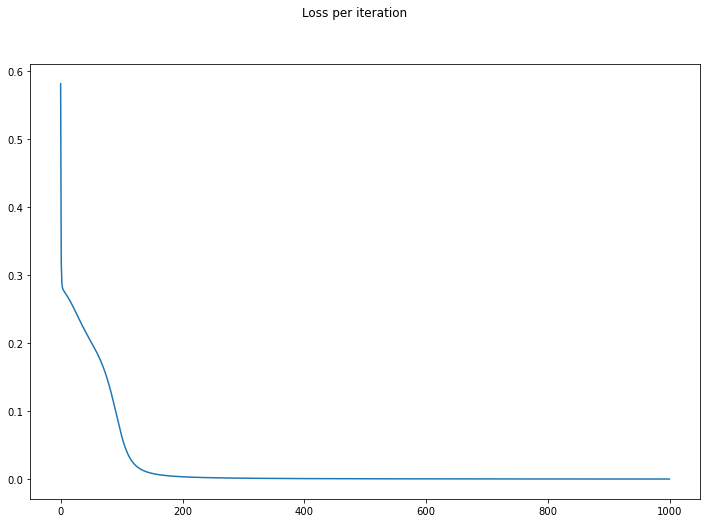

In [8]:
# train
model.use(mse, mse_prime)
model.fit(X_train, y_train, epochs=1000, learning_rate=0.1)
model.plot_loss_per_iteration()

# test
out = model.predict(X_train)
print(out)

#### Running on MNIST

In [9]:
# test on MNIST data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [10]:
print("Training data shape: ", X_train.shape) # (60000, 28, 28) -- 60000 images, each 28x28 pixels
print("Test data shape", X_test.shape) # (10000, 28, 28) -- 10000 images, each 28x28

Training data shape:  (60000, 28, 28)
Test data shape (10000, 28, 28)


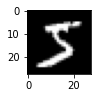

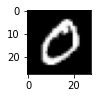

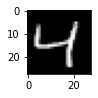

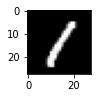

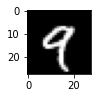

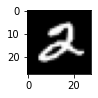

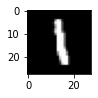

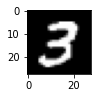

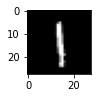

In [11]:
for i in range(9):  
    plt.subplot(330 + 1 + i)
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray'))
    plt.show()

In [12]:
def reshape_data(data):
    """
    Reshape input data and normalise for better model.
    """
    data = data.reshape(data.shape[0], 1, 28*28)
    data = data.astype('float32')
    data /= 255
    return data

X_train = reshape_data(X_train)
X_test = reshape_data(X_test)

# categorical one-hot
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)

In [13]:
# Network
model = NeuralNetwork()
model.add(LayerCreate(28*28, 100))
model.add(ActivationLayer(tanh, tanh_derivative))
model.add(LayerCreate(100, 50))
model.add(ActivationLayer(leaky_relu, leaky_relu_derivative))
model.add(LayerCreate(50, 10))
model.add(ActivationLayer(softmax, softmax_derivative))

In [14]:
# run model on 20000 samples, otherwise will take really long
model.use(mse, mse_prime)
model.fit(X_train[0:20000], y_train[0:20000], epochs=50, learning_rate=0.1)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [08:27<00:00, 10.14s/it]


In [15]:
def classify_pred(arr):
    """
    Run array of probabilities through this to get prediction.
    """
    return np.argmax(arr)

In [16]:
# test on 5 samples
out = model.predict(X_test[0:5])
print("Predictions:")
for i in out:
    temp = classify_pred(i)
    print(temp)
print("True Value:")
for i in y_test[0:5]:
    temp = classify_pred(i)
    print(temp)

Predictions:
7
2
1
0
4
True Value:
7
2
1
0
4


In [17]:
# predict all
y_pred_probs = model.predict(X_test)
y_pred = []
y_true = []
for i in range(len(y_pred_probs)):
    y_pred.append(classify_pred(y_pred_probs[i]))
    y_true.append(classify_pred(y_test[i]))

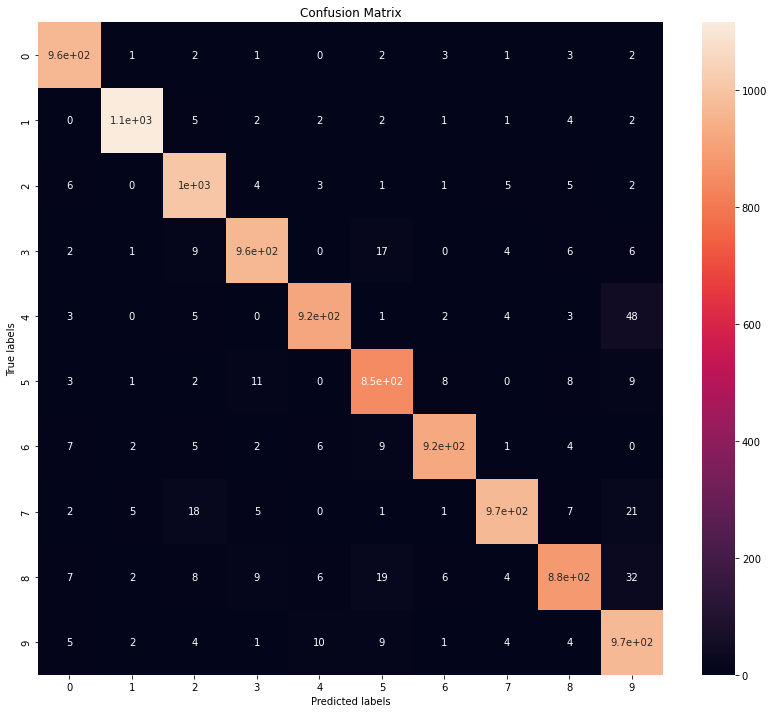

In [18]:
#Create the confusion matrix using test data and predictions
cm = confusion_matrix(y_true, y_pred)
#plot the confusion matrix
plt.figure(figsize=(14, 12))
ax = plt.subplot()
sns.heatmap(cm,annot=True,ax=ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()

In [19]:
matrix = classification_report(y_true, y_pred, labels=[0,1,2,3,4,5,6,7,8,9])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       980
           1       0.99      0.98      0.99      1135
           2       0.95      0.97      0.96      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.93      0.95       982
           5       0.93      0.95      0.94       892
           6       0.98      0.96      0.97       958
           7       0.98      0.94      0.96      1028
           8       0.95      0.90      0.93       974
           9       0.89      0.96      0.92      1009

    accuracy                           0.96     10000
   macro avg       0.96      0.96      0.96     10000
weighted avg       0.96      0.96      0.96     10000



We can see from our results that we have a 96% overall accuracy with just 20000 samples trained on (with a potential for 60000 if given more computational power/implement a different gradient descent method that is more efficient). 

It took 8 minutes 27 seconds to run this model, which is a good time considering it is a neural network built from scratch without much optimization.

## References



Aflack, O. (2018). Neural Network from scratch in Python. Retrieved from https://towardsdatascience.com/math-neural-network-from-scratch-in-python-d6da9f29ce65

Bhandari, A. (2020). Everything you Should Know about Confusion Matrix for Machine Learning. Retrieved from https://www.analyticsvidhya.com/blog/2020/04/confusion-matrix-machine-learning/

Brownlee, J. (2020). What Is Argmax in Machine Learning? Retrieved from https://machinelearningmastery.com/argmax-in-machine-learning/#:~:text=Argmax%20is%20an%20operation%20that,function%20is%20preferred%20in%20practice

Hansen, C. (2020). Neural Network From Scratch with NumPy and MNIST. Retrieved from https://mlfromscratch.com/neural-network-tutorial/#/

Loy, J. (2018). How to build your own Neural Network from scratch in Python. Retrieved from https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6

Minerva IL181 Session 2. (2022). Breakout 2: PCW and Regularization. Retrieved from https://deepnote.com/project/IL181-Session-2-Fundamentals-II-pdyDWwcqQbqegN3EPrtkiw/%2FBreakout_2_Group_1.ipynb/#5cbaacbf-acf8-4adc-939c-2125277aa6d1

Ruder, S. (2016). An overview of gradient descent optimization algorithms. Retrieved from https://ruder.io/optimizing-gradient-descent/

Skalski, P. (2018). Let’s code a Neural Network in plain NumPy. Retrieved from https://towardsdatascience.com/lets-code-a-neural-network-in-plain-numpy-ae7e74410795

Wang, C-F. (2018). Calculating Gradient Descent Manually. Retrieved from https://towardsdatascience.com/calculating-gradient-descent-manually-6d9bee09aa0b

---

## Previous Attempts to Learn

### Simple Implementation

In [489]:
# using https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6

### UTILITY MATHEMATICAL FUNCTIONS

# Sigmoid activation function
def sigmoid(x):
    return 1.0/(1+ np.exp(-x))

# Sigmoid derivative for gradient descent in backprop
def sigmoid_derivative(x):
    return x * (1.0 - x)

# for final softmax layer
def softmax(z):
    """Compute softmax values for each sets of scores in x."""
    print(z)
    print(f"VECTOR: {np.exp(z)}")
    print(f"SUM: {np.sum(np.exp(z), axis=0)}")
    e_x = np.exp(z - z.max())
    return e_x / np.sum(e_x, axis=0)
    #return e_z / e_z.sum(axis=0, keepdims=True)

def softmax_derivative(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0, keepdims=True)

# for leaky relu layer
# we use leaky here to avoid vanishing gradient problem
def leaky_relu(x):
    return np.where(x > 0, x, x * 0.001)
    
def leaky_relu_derivative(x):
    return np.where(x < 0, 0.001, 1)

# Multi-class cross-entropy loss function
def multi_cross_entropy(y_pre, y):
    print(y_pre)
    loss=-np.sum(y*np.log(y_pre))
    return loss/float(y_pre.shape[0])

In [507]:
### NEURAL NETWORK CLASS
class NeuralNetwork:
    def __init__(self, x, y, activation_function, af_gradient, loss_function):
        # there are 10 different numbers, so we have an input layer of 10.
        self.input = x # set input
        self.weights1 = np.random.rand(self.input.shape[1],50) # layer 1 weights
        self.weights2 = np.random.rand(50,10) # layer 2 weights
        self.weights3 = np.random.rand(10,10) # layer 3 weights
        self.y = y # output size
        self.output = np.zeros(self.y.shape) # set up output
        self.activation_function = activation_function
        self.loss_function = loss_function
        self.af_gradient = af_gradient
        self.loss_history = [] # set up loss function array
        
    def feedforward(self):
        """
        Run weights through activation function in sequence to get to output.
        """
        print(f"weights1: {self.weights1}")
        self.layer1 = self.activation_function(np.dot(self.input, self.weights1))
        print(f"LAYER1 = {self.layer1}")
        self.layer2 = self.activation_function(np.dot(self.layer1, self.weights2))
        self.output = softmax(np.dot(self.layer2, self.weights3))
        
        # append loss at end out weight passing through NN
        self.loss_history.append(self.loss_function(self.output, self.y))
    
    def backpropagation_gd(self):
        """
        We work backwards, using the chain rule, derivative of activation function, and the transpose of weight matrix
        to find the derivative of our loss function. This is using gradient descent.
        """
        # dot product of layer2 weights transposed, with (2*difference between y and output*activation function gradient)
        d_weights3 = np.dot(self.layer2.T, (2*(self.y - self.output) * softmax_derivative(self.output)))
        # again, chain rule using previous calculations
        d_weights2 =  np.dot(self.layer1.T,  (np.dot(2*(self.y - self.output) * self.af_gradient(self.output), self.weights3.T) * self.af_gradient(self.layer2)))
        d_weights1 = np.dot(self.input.T,  (np.dot(2*(self.y - self.output) * self.af_gradient(self.output), self.weights2.T) * self.af_gradient(self.layer1)))

        # we then update the weights using this derivative of the loss function
        self.weights1 += d_weights1
        self.weights2 += d_weights2
        self.weights3 += d_weights3
        
    def train(self, iterations):
        for i in tqdm.tqdm(range(iterations)):
            self.feedforward()
            self.backpropagation_gd()
            
    def plot_loss_per_iteration(self):
        a4_dims = (11.7, 8.27)
        iterations = [i for i in range(len(self.loss_history))]
        plt.figure(figsize=a4_dims)
        plt.plot(iterations, self.loss_history)
        plt.suptitle('Loss per iteration', fontsize=12)
        

In [524]:
nn = NeuralNetwork(X_train, y_train, leaky_relu, leaky_relu_derivative, multi_cross_entropy)
nn.train(1)

  0%|                                                                                                               | 0/1 [00:00<?, ?it/s]

weights1: [[0.26792746 0.03642086 0.47690898 ... 0.65241207 0.07678089 0.55353486]
 [0.1816278  0.24702717 0.229208   ... 0.61497263 0.66308378 0.31710673]
 [0.76215828 0.15314635 0.14832372 ... 0.64453016 0.98366745 0.65771891]
 ...
 [0.46245683 0.01126835 0.8136033  ... 0.72074003 0.9305517  0.56066853]
 [0.6547219  0.60867753 0.95748858 ... 0.95167416 0.41037387 0.40059171]
 [0.61931785 0.85277644 0.88905725 ... 0.25479949 0.35958875 0.71718486]]
LAYER1 = [[13650.7896587  13383.45236081 14830.74066124 ... 12130.29938744
  13830.51447355 12115.71806256]
 [15081.65269538 15326.19177906 16388.04105355 ... 14009.49503686
  15478.29316219 16062.04460395]
 [10675.39134806  9734.22294266  8787.77052096 ...  9219.73197423
   9612.91615525 10010.95867039]
 ...
 [11226.08609812 10475.380367   11616.78006219 ... 10086.70737261
  10849.2165663  11836.15537543]
 [10546.61645832 10404.13435608 10785.43955391 ... 10282.50653619
  10522.28498636 10489.36078193]
 [ 9654.20886961 10079.68535625  9914

/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2741386404.py:15: RuntimeWarning: overflow encountered in exp
  print(f"VECTOR: {np.exp(z)}")
/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2741386404.py:16: RuntimeWarning: overflow encountered in exp
  print(f"SUM: {np.sum(np.exp(z), axis=0)}")
/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2741386404.py:17: RuntimeWarning: overflow encountered in exp
  return np.exp(z) / np.sum(np.exp(z), axis=0)
/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2741386404.py:17: RuntimeWarning: invalid value encountered in true_divide
  return np.exp(z) / np.sum(np.exp(z), axis=0)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


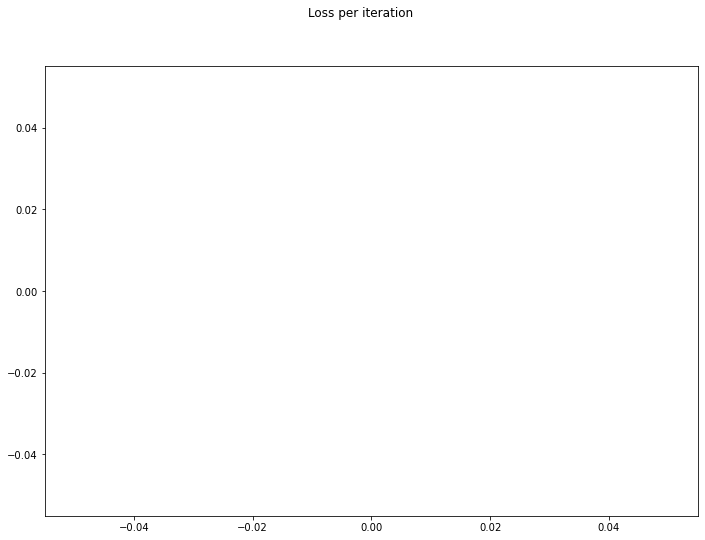

In [525]:
print(nn.output)
nn.plot_loss_per_iteration()

In [519]:
# from https://mlfromscratch.com/neural-network-tutorial/#/

class DeepNeuralNetwork():
    def __init__(self, sizes, epochs=10, l_rate=0.001):
        self.sizes = sizes
        self.epochs = epochs
        self.l_rate = l_rate

        # we save all parameters in the neural network in this dictionary
        self.params = self.initialization()

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (np.exp(-x))/((np.exp(-x)+1)**2)
        return 1/(1 + np.exp(-x))

    def softmax(self, x, derivative=False):
        # Numerically stable with large exponentials
        exps = np.exp(x - x.max())
        if derivative:
            return exps / np.sum(exps, axis=0) * (1 - exps / np.sum(exps, axis=0))
        return exps / np.sum(exps, axis=0)

    def initialization(self):
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        params = {
            "W1":np.random.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            "W2":np.random.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            "W3":np.random.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

        return params

    def forward_pass(self, x_train):
        params = self.params

        # input layer activations becomes sample
        params['A0'] = x_train

        # input layer to hidden layer 1
        params['Z1'] = np.dot(params["W1"], params['A0'])
        params['A1'] = self.sigmoid(params['Z1'])

        # hidden layer 1 to hidden layer 2
        params['Z2'] = np.dot(params["W2"], params['A1'])
        params['A2'] = self.sigmoid(params['Z2'])

        # hidden layer 2 to output layer
        params['Z3'] = np.dot(params["W3"], params['A2'])
        params['A3'] = self.softmax(params['Z3'])

        return params['A3']

    def backward_pass(self, y_train, output):
        '''
            This is the backpropagation algorithm, for calculating the updates
            of the neural network's parameters.

            Note: There is a stability issue that causes warnings. This is 
                  caused  by the dot and multiply operations on the huge arrays.
                  
                  RuntimeWarning: invalid value encountered in true_divide
                  RuntimeWarning: overflow encountered in exp
                  RuntimeWarning: overflow encountered in square
        '''
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = 2 * (output - y_train) / output.shape[0] * self.softmax(params['Z3'], derivative=True)
        change_w['W3'] = np.outer(error, params['A2'])

        # Calculate W2 update
        error = np.dot(params['W3'].T, error) * self.sigmoid(params['Z2'], derivative=True)
        change_w['W2'] = np.outer(error, params['A1'])

        # Calculate W1 update
        error = np.dot(params['W2'].T, error) * self.sigmoid(params['Z1'], derivative=True)
        change_w['W1'] = np.outer(error, params['A0'])

        return change_w

    def update_network_parameters(self, changes_to_w):
        '''
            Update network parameters according to update rule from
            Stochastic Gradient Descent.

            θ = θ - η * ∇J(x, y), 
                theta θ:            a network parameter (e.g. a weight w)
                eta η:              the learning rate
                gradient ∇J(x, y):  the gradient of the objective function,
                                    i.e. the change for a specific theta θ
        '''
        
        for key, value in changes_to_w.items():
            self.params[key] -= self.l_rate * value

    def compute_accuracy(self, x_val, y_val):
        '''
            This function does a forward pass of x, then checks if the indices
            of the maximum value in the output equals the indices in the label
            y. Then it sums over each prediction and calculates the accuracy.
        '''
        predictions = []

        for x, y in zip(x_val, y_val):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == np.argmax(y))
        
        return np.mean(predictions)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        for iteration in range(self.epochs):
            for x,y in zip(x_train, y_train):
                output = self.forward_pass(x)
                changes_to_w = self.backward_pass(y, output)
                self.update_network_parameters(changes_to_w)
            
            accuracy = self.compute_accuracy(x_val, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s, Accuracy: {2:.2f}%'.format(
                iteration+1, time.time() - start_time, accuracy * 100
            ))
            
dnn = DeepNeuralNetwork(sizes=[784, 128, 64, 10])
dnn.train(X_train, y_train, X_test, y_test)

/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2571412226.py:13: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-x))
/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2571412226.py:12: RuntimeWarning: overflow encountered in exp
  return (np.exp(-x))/((np.exp(-x)+1)**2)
/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2571412226.py:12: RuntimeWarning: overflow encountered in square
  return (np.exp(-x))/((np.exp(-x)+1)**2)
/var/folders/9c/7bqqxzp11xx4mn0mks5l_b3h0000gn/T/ipykernel_3285/2571412226.py:12: RuntimeWarning: invalid value encountered in true_divide
  return (np.exp(-x))/((np.exp(-x)+1)**2)


Epoch: 1, Time Spent: 61.16s, Accuracy: 100.00%
Epoch: 2, Time Spent: 123.88s, Accuracy: 100.00%
Epoch: 3, Time Spent: 189.94s, Accuracy: 100.00%
Epoch: 4, Time Spent: 262.12s, Accuracy: 100.00%
Epoch: 5, Time Spent: 327.72s, Accuracy: 100.00%
Epoch: 6, Time Spent: 400.28s, Accuracy: 100.00%
Epoch: 7, Time Spent: 475.47s, Accuracy: 100.00%
Epoch: 8, Time Spent: 536.92s, Accuracy: 100.00%
Epoch: 9, Time Spent: 610.13s, Accuracy: 100.00%
Epoch: 10, Time Spent: 677.50s, Accuracy: 100.00%


#### Running on IRIS

In [52]:
from sklearn import datasets
iris = datasets.load_iris()

In [53]:
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)

In [54]:
df["target"] = iris.target

In [55]:
X = df.drop(['target'], axis=1)
y = df["target"]

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=5)

In [74]:
# Network
model = NeuralNetwork()
model.add(LayerCreate(4, 16))
model.add(ActivationLayer(tanh, tanh_derivative))
model.add(LayerCreate(16, 64))
model.add(ActivationLayer(leaky_relu, leaky_relu_derivative))
model.add(LayerCreate(64, 4))
model.add(ActivationLayer(softmax, softmax_derivative))

In [75]:
model.use(mse, mse_prime)
model.fit(np.array(X_train), np.array(y_train), epochs=15, learning_rate=0.1)

  0%|                                                                                                              | 0/15 [00:00<?, ?it/s]


ValueError: shapes (4,) and (1,16) not aligned: 4 (dim 0) != 1 (dim 0)